[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bamirandab/nlp-disaster-tweets/blob/main/notebooks/model.ipynb)

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bamirandab","key":"acf8e7fbd28901f7d9fc992f669fd7d0"}'}

In [2]:
from google.colab import files
files.upload() #upload clean.py

Saving clean.py to clean.py


{'clean.py': b'import re\r\nimport nltk\r\nnltk.download(\'punkt\')\r\nfrom nltk.corpus import stopwords\r\nfrom nltk.tokenize import word_tokenize\r\nimport mapply\r\n\r\n\r\nmapply.init(\r\n    n_workers=-1,\r\n    chunk_size=100,\r\n    max_chunks_per_worker=8,\r\n    progressbar=False\r\n)\r\n\r\nnltk.download(\'stopwords\')\r\nstop_words = stopwords.words()\r\n\r\ndef search_keywords(x, tweet):\r\n  result = re.search(\'[{letter}]\\w+\'.format(letter=x),tweet)\r\n  if result: \r\n    return True\r\n  else:\r\n    return False\r\n\r\ndef clean_tweet(tweet):\r\n  tweet_tokens = re.sub(\'\\s+\', \' \', tweet.lower()).split(\' \')\r\n  tweet_clean = \' \'.join([word for word in tweet_tokens if not word in stop_words])\r\n  return tweet_clean\r\n\r\n\r\ndef drop_word(x, word, tweet):\r\n  return re.sub(\'[{letter}]\\w+\'.format(letter=x),word,tweet)\r\n\r\ndef drop_url(tweet):\r\n  return re.sub(r\'http\\S+\',\'url\',tweet)\r\n\r\n\r\ndef clean_df(x):\r\n    x_clean_temp = x["text"].ma

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle competitions download -c nlp-getting-started -p ../data

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 125MB/s]


In [5]:
!pip install mapply

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 5.7 MB/s 
     |████████████████████████████████| 115 kB 62.1 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 


In [63]:
from clean import clean_df
from zipfile import ZipFile
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [64]:
path = os.path.join('../data/nlp-getting-started.zip')

with ZipFile(path, 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
   zipObj.extractall('../data')

In [65]:
data_path = '../data/'
train_df = pd.read_csv(data_path + 'train.csv', encoding='utf-8')
test_df = pd.read_csv(data_path + 'test.csv', encoding='utf-8')

In [66]:
train_labels = train_df["target"].to_list()
train_sentences = clean_df(train_df)
test_sentences = clean_df(test_df)

In [116]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 16

# Output dimensions of the Embedding layer
embedding_dim = 32

In [117]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(training_padded.shape)
# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(train_labels)

(7613, 16)


In [118]:
X_train, X_test, y_train, y_test = train_test_split(training_padded,training_labels,stratify = training_labels, 
                                                    test_size=0.1, random_state=42)



In [124]:

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 16, 32)            320000    
                                                                 
 bidirectional_30 (Bidirecti  (None, 16, 512)          591872    
 onal)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 16, 512)           0         
                                                                 
 bidirectional_31 (Bidirecti  (None, 16, 256)          656384    
 onal)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 16, 256)           0         
                                                                 
 bidirectional_32 (Bidirecti  (None, 128)            

In [125]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [126]:
num_epochs = 20

# Train the model
history = model.fit(X_train, y_train, epochs=num_epochs, verbose=1,
                    batch_size=2**5 ,validation_data = (X_test, y_test))

Epoch 1/20
215/215 [==============================] - 15s 27ms/step - loss: 0.5332 - accuracy: 0.7324 - val_loss: 0.4773 - val_accuracy: 0.7795
Epoch 2/20
215/215 [==============================] - 4s 19ms/step - loss: 0.3321 - accuracy: 0.8698 - val_loss: 0.5386 - val_accuracy: 0.7848
Epoch 3/20
215/215 [==============================] - 4s 19ms/step - loss: 0.2456 - accuracy: 0.9142 - val_loss: 0.5804 - val_accuracy: 0.7769
Epoch 4/20
215/215 [==============================] - 4s 19ms/step - loss: 0.1908 - accuracy: 0.9349 - val_loss: 0.6236 - val_accuracy: 0.7546
Epoch 5/20
215/215 [==============================] - 4s 18ms/step - loss: 0.1721 - accuracy: 0.9413 - val_loss: 0.6823 - val_accuracy: 0.7598
Epoch 6/20
215/215 [==============================] - 4s 18ms/step - loss: 0.1456 - accuracy: 0.9524 - val_loss: 0.7665 - val_accuracy: 0.7559
Epoch 7/20
215/215 [==============================] - 4s 18ms/step - loss: 0.1258 - accuracy: 0.9584 - val_loss: 0.8815 - val_accuracy: 0.750

In [73]:
testing_labels = model.predict(testing_padded)

In [74]:
test_labels = [1 if label > 0.50 else 0 for label in testing_labels ]

In [75]:
from sklearn.metrics import confusion_matrix

y_test_predict = [1 if label > 0.50 else 0 for label in model.predict(X_test) ]
confusion_matrix(y_test, y_test_predict)

array([[667, 202],
       [206, 448]])

In [82]:
test_data_evaluate = pd.DataFrame()
deafult_words = ["hashtag", "amp","mention","url"]
words_index = {y: x for x, y in tokenizer.word_index.items()}

test_data_evaluate["tokens_text"] = [[words_index[word + 1] for word in row] for row in X_test.tolist()]
test_data_evaluate["tokens_text_clean"] = test_data_evaluate["tokens_text"].apply(lambda x: [word for word in x if word not in deafult_words])
test_data_evaluate["Y"] = y_test
test_data_evaluate["Yhat"] = y_test_predict
test_data_evaluate_diff = test_data_evaluate.query('Y != Yhat').copy()

test_data_evaluate_diff["text"] = test_data_evaluate_diff["tokens_text_clean"].apply(lambda x: list(set(x)))
test_data_evaluate_diff

,tokens_text,tokens_text_clean,Y,Yhat,text
0,"[amp, decisions, tote, army, challenged, url, ...","[decisions, tote, army, challenged, <OOV>, <OO...",0,1,"[decisions, challenged, army, <OOV>, tote]"
5,"[pretty, military, collided, flash, attacked, ...","[pretty, military, collided, flash, attacked, ...",1,0,"[military, expected, parker, collided, attacke..."
7,"[land, ev, emotionally, <OOV>, <OOV>, <OOV>, <...","[land, ev, emotionally, <OOV>, <OOV>, <OOV>, <...",1,0,"[land, emotionally, <OOV>, ev]"
12,"[url, man, water, thursday, gun, hashtag, <OOV...","[man, water, thursday, gun, <OOV>, <OOV>, <OOV...",1,0,"[water, thursday, gun, <OOV>, man]"
14,"[agree, chase, matter, is, play, rendered, new...","[agree, chase, matter, is, play, rendered, new...",0,1,"[matter, chase, california, rendered, <OOV>, p..."
...,...,...,...,...,...
1492,"[video, news, parenthood, mom, cranes, nuclear...","[video, news, parenthood, mom, cranes, nuclear...",0,1,"[lt, parenthood, nuclear, mom, <OOV>, news, cr..."
1500,"[wave, url, respond, url, support, squeeze, ur...","[wave, respond, support, squeeze, 7, shook, de...",1,0,"[respond, 7, message, details, <OOV>, support,..."
1507,"[mention, ebay, ok, mention, mention, mention,...","[ebay, ok, <OOV>, <OOV>, <OOV>, <OOV>, <OOV>, ...",1,0,"[ok, <OOV>, ebay]"
1514,"[amp, old, disney's, mention, cree, lighting, ...","[old, disney's, cree, lighting, runner, <OOV>,...",0,1,"[old, <OOV>, lighting, disney's, runner, cree]"


In [83]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

word cloud y = 1


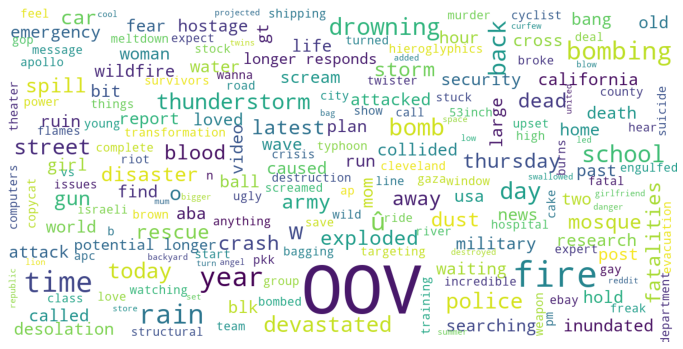

word cloud y = 0


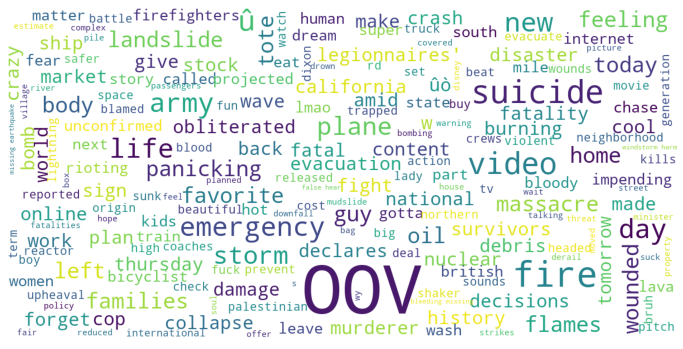

In [84]:
print('word cloud y = 1')
show_wordcloud(' '.join([' '.join(row) for row in test_data_evaluate_diff.query('Y == 1')['text'].to_list()]))


print('word cloud y = 0')
show_wordcloud(' '.join([' '.join(row) for row in test_data_evaluate_diff.query('Y == 0')['text'].to_list()]))

In [79]:
train_data_evaluate = pd.DataFrame()
words_index = {y: x for x, y in tokenizer.word_index.items()}

train_data_evaluate["tokens_text"] = [[words_index[word + 1] for word in row] for row in X_train.tolist()]
train_data_evaluate["tokens_text_clean"] = train_data_evaluate["tokens_text"].apply(lambda x: [word for word in x if word not in deafult_words])
y_train_predict = [1 if label > 0.50 else 0 for label in model.predict(X_train) ]

train_data_evaluate["Y"] = y_train
train_data_evaluate["Yhat"] = y_train_predict
train_data_evaluate_diff = train_data_evaluate.query('Y == Yhat').copy()

train_data_evaluate_diff["text"] = train_data_evaluate["tokens_text_clean"].apply(lambda x: list(set(x)))
train_data_evaluate_diff

,tokens_text,tokens_text_clean,Y,Yhat,text
1,"[cd, sixth, yesterday, monkeys, economic, arre...","[cd, sixth, yesterday, monkeys, economic, arre...",0,0,"[guys, yesterday, cd, sixth, <OOV>, monkeys, a..."
2,"[bigstar, 4got, dudes, ahead, free, burning, 0...","[bigstar, 4got, dudes, ahead, free, burning, 0...",0,0,"[dudes, 4got, <OOV>, bigstar, tweet, free, ahe..."
3,"[amp, british, wave, 4, <OOV>, <OOV>, <OOV>, <...","[british, wave, 4, <OOV>, <OOV>, <OOV>, <OOV>,...",0,0,"[british, 4, wave, <OOV>]"
4,"[heat, local, phone, 10, floated, food, suspec...","[heat, local, phone, 10, floated, food, suspec...",1,1,"[phone, 10, <OOV>, floated, forest, quiz, heat..."
5,"[it, url, 4, 87, typhoon, mention, content, ur...","[it, 4, 87, typhoon, content, uribe, attack, a...",0,0,"[typhoon, 4, uribe, 87, it, <OOV>, content, ad..."
...,...,...,...,...,...
6085,"[reaching, yellow, times, motion, cabins, reid...","[reaching, yellow, times, motion, cabins, reid...",1,1,"[motion, maca, cabins, denver, ibrahimmisau, <..."
6086,"[year, amp, defeater, factory, industry, closi...","[year, defeater, factory, industry, closing, h...",1,1,"[houses, year, enjoyed, make, industry, closin..."
6087,"[mention, xbox, rule, faction, flags, tomorrow...","[xbox, rule, faction, flags, tomorrow, xp', pr...",0,0,"[xp', flags, rule, revolution, property, facti..."
6088,"[hour, whipped, sunday, planted, join, stock, ...","[hour, whipped, sunday, planted, join, stock, ...",0,0,"[gold, whipped, hour, too, <OOV>, planted, sto..."


word cloud y = 1


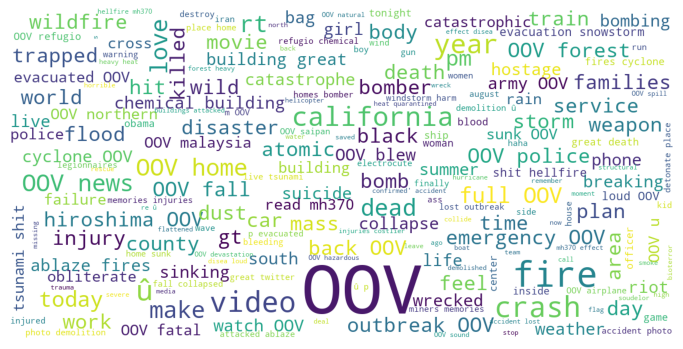

word cloud y = 0


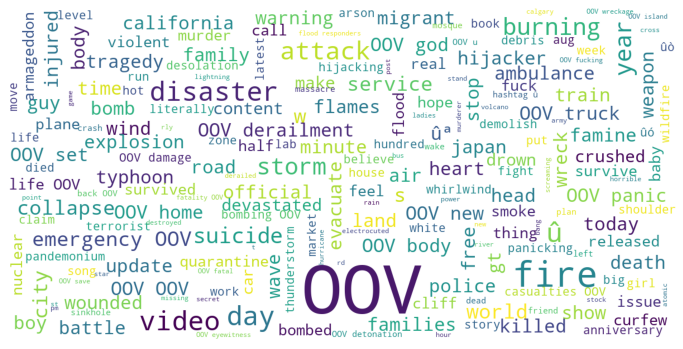

In [80]:
print('word cloud y = 1')
show_wordcloud(' '.join([' '.join(row) for row in train_data_evaluate_diff.query('Y == 1')['text'].to_list()]))


print('word cloud y = 0')
show_wordcloud(' '.join([' '.join(row) for row in train_data_evaluate_diff.query('Y == 0')['text'].to_list()]))

In [81]:
test_df['target'] = pd.Series(test_labels)
print(test_df.shape)
test_df[['id','target']].to_csv("test.csv", index=False)
test_df.target.sum()

(3263, 5)


1379